Dataset cargado exitosamente desde: Cancer.csv

Análisis Estructural
Número de Instancias (Filas): 4024
Dimensiones (Columnas): 16

Tratamiento de Valores Perdidos

Conversión de Atributos Categóricos

Tratamiento de Outliers (Winsorize)
Aplicado Winsorize a 5 características numéricas originales.

Normalización (MinMaxScaler)
Características numéricas (5 columnas) normalizadas (MinMaxScaler).

Estructura del Dataset Final y Normalizado
        Age  Tumor Size  Regional Node Examined  Reginol Node Positive  \
0  1.000000    0.000000                0.846154               0.000000   
1  0.379310    0.393939                0.461538               0.285714   
2  0.655172    0.818182                0.461538               0.428571   
3  0.655172    0.136364                0.000000               0.000000   
4  0.275862    0.484848                0.038462               0.000000   

   Survival Months  Race_Other  Race_White  Marital Status_Married  \
0         0.441558       False        True  

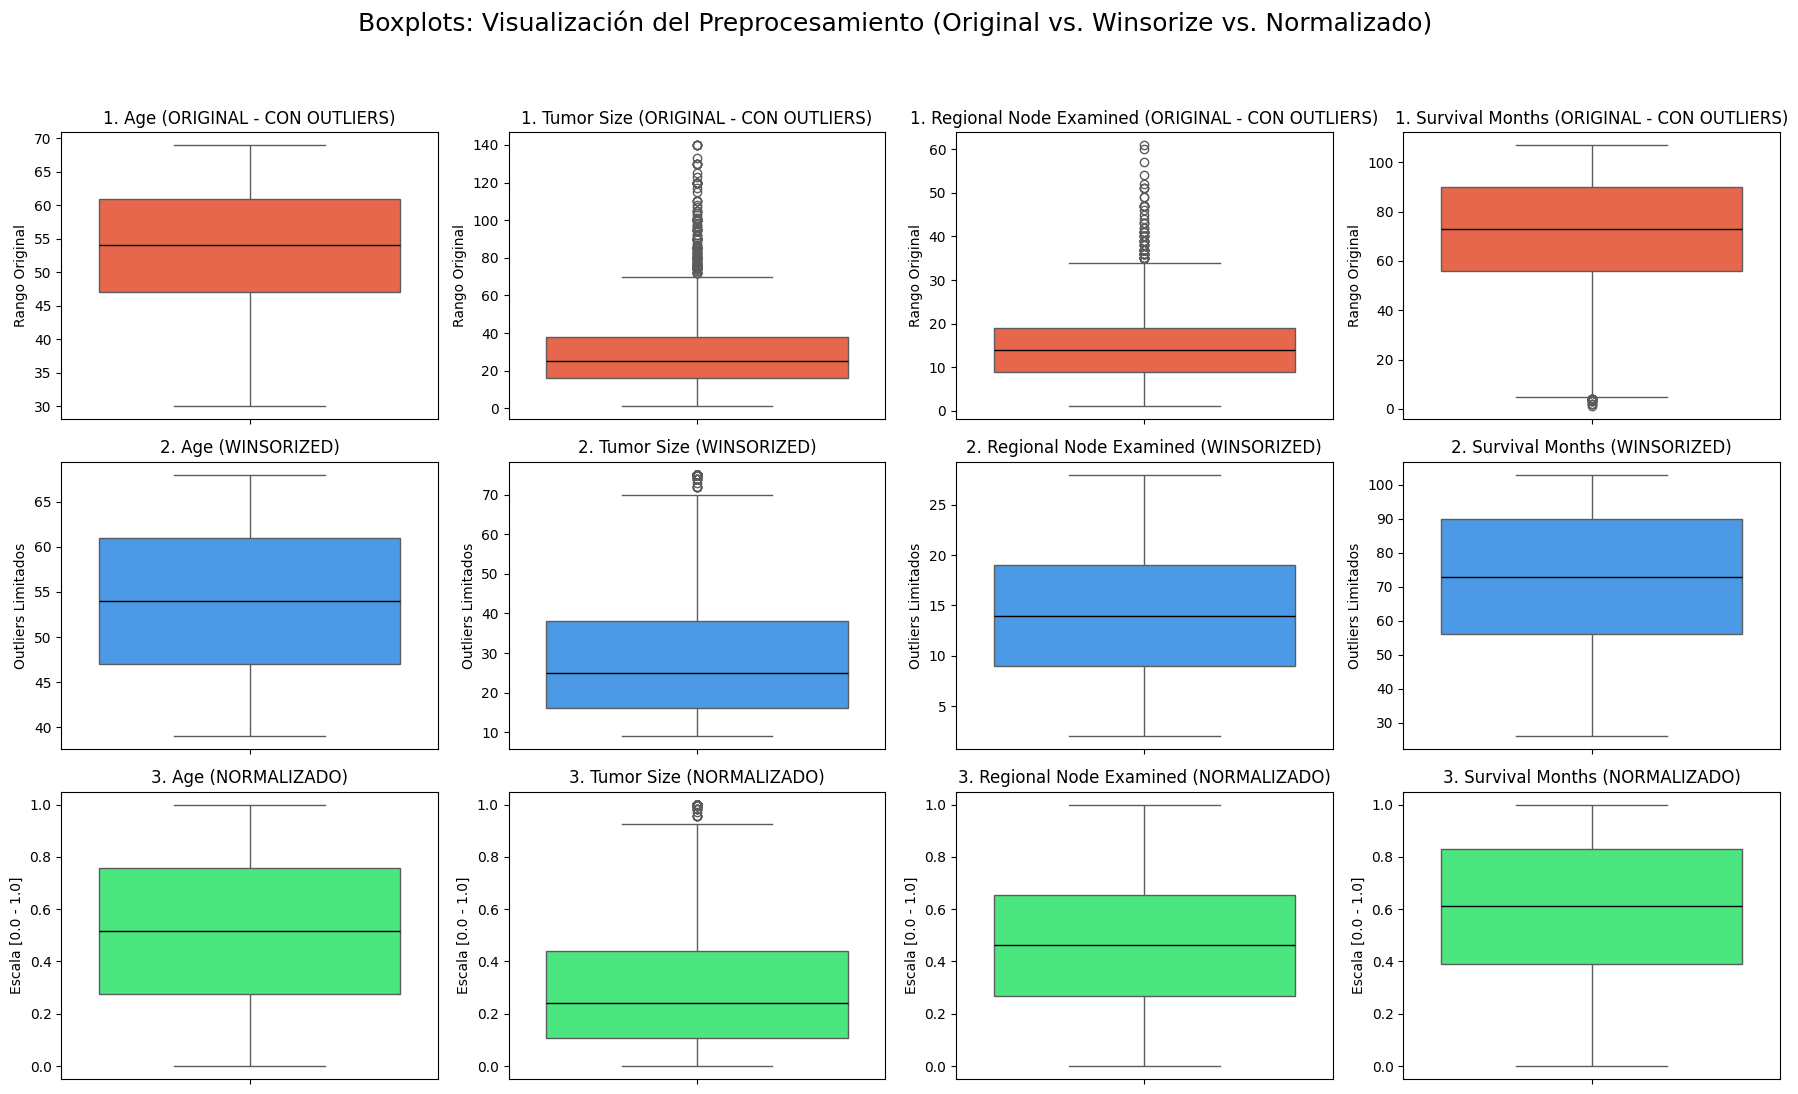

In [10]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'Cancer.csv' 

try:
    df = pd.read_csv(file_path)
    print(f"Dataset cargado exitosamente desde: {file_path}")
    
   
    if 'id' in df.columns:
        df.drop('id', axis=1, inplace=True)
    if 'Unnamed: 32' in df.columns: 
        df.drop('Unnamed: 32', axis=1, inplace=True)

except FileNotFoundError:
    print("Por favor, verifica el nombre del archivo ('Cancer.csv') y la ruta.")
    exit()
    

print("\nAnálisis Estructural")
print(f"Número de Instancias (Filas): {df.shape[0]}")
print(f"Dimensiones (Columnas): {df.shape[1]}")


print("\nTratamiento de Valores Perdidos")
missing_percent = df.isnull().sum() * 100 / len(df)

for col in missing_percent.index:
    # Solo imputar si es numérico y excede el 10%
    if missing_percent[col] > 10 and df[col].dtype != 'object':
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Imputando la columna '{col}' con la Mediana.")
    

print("\nConversión de Atributos Categóricos")
TARGET_COL = 'Status' 
TARGET_ENCODED = 'Status_encoded'
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col == TARGET_COL:
        
        le = LabelEncoder()
        df[TARGET_ENCODED] = le.fit_transform(df[col])
        df.drop(col, axis=1, inplace=True)
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)


#  ELIMINACIÓN DE OUTLIERS CON WINSORIZE 

print("\nTratamiento de Outliers (Winsorize)")
df_winsorized = df.copy() 

numerical_original = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']
cols_to_winsorize = [col for col in numerical_original if col in df_winsorized.columns]

for col in cols_to_winsorize:
    # Aplicar winsorize con límites del 5% inferior y 5% superior
    df_winsorized[col] = winsorize(df_winsorized[col], limits=[0.05, 0.05])
    
print(f"Aplicado Winsorize a {len(cols_to_winsorize)} características numéricas originales.")
df_final = df_winsorized.copy()


#  NORMALIZACIÓN DEL DATASET 

print("\nNormalización (MinMaxScaler)")
scaler = MinMaxScaler()


cols_to_scale = df_final.select_dtypes(include=np.number).columns.tolist()


if TARGET_ENCODED in cols_to_scale:
    cols_to_scale.remove(TARGET_ENCODED)

if cols_to_scale:
    df_final[cols_to_scale] = scaler.fit_transform(df_final[cols_to_scale])
    print(f"Características numéricas ({len(cols_to_scale)} columnas) normalizadas (MinMaxScaler).")

print("\nEstructura del Dataset Final y Normalizado")
print(df_final.head())




print("\nGenerando Gráficas de Validación (Boxplots)")

cols_to_plot_fixed = ['Age', 'Tumor Size', 'Regional Node Examined', 'Survival Months']
cols_to_plot_fixed = [col for col in cols_to_plot_fixed if col in df.columns]

if cols_to_plot_fixed:
    
    fig, axes = plt.subplots(3, len(cols_to_plot_fixed), figsize=(18, 11)) # Aumentamos el tamaño
    fig.suptitle('Boxplots: Visualización del Preprocesamiento (Original vs. Winsorize vs. Normalizado)', 
                 fontsize=18, y=1.02) # Título general

    for i, col in enumerate(cols_to_plot_fixed):
        
       
        sns.boxplot(y=df[col], ax=axes[0, i], color='#FF5733', medianprops={'color': 'black'})
        axes[0, i].set_title(f'1. {col} (ORIGINAL - CON OUTLIERS)', fontsize=12)
        axes[0, i].set_ylabel('Rango Original', fontsize=10)
        
      
        sns.boxplot(y=df_winsorized[col], ax=axes[1, i], color='#3399FF', medianprops={'color': 'black'})
        axes[1, i].set_title(f'2. {col} (WINSORIZED)', fontsize=12)
        axes[1, i].set_ylabel('Outliers Limitados', fontsize=10)

     
        sns.boxplot(y=df_final[col], ax=axes[2, i], color='#33FF77', medianprops={'color': 'black'})
        axes[2, i].set_title(f'3. {col} (NORMALIZADO)', fontsize=12)
        axes[2, i].set_ylabel('Escala [0.0 - 1.0]', fontsize=10)
        axes[2, i].set_yticks(np.arange(0, 1.1, 0.2)) # Escala clara de 0 a 1
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("Advertencia: No se pudieron graficar las columnas de ejemplo. Verifique los nombres.")